## Imports

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.callbacks import EarlyStopping

In [21]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from gensim.models import Word2Vec


In [22]:
import numpy as np

from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense

In [23]:
import pandas as pd

In [24]:
from tensorflow.keras.utils import set_random_seed


In [25]:
set_random_seed(8)

# Setting seed & importing data

In [26]:
tf.random.set_seed(8)

df = pd.read_csv('original_data.csv')
df.head()

,headline,label
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [27]:
df.isna().sum()

headline    0
label       0
dtype: int64

In [28]:
df.shape

(26709, 2)

## Splitting data

In [29]:
X = df["headline"]
y = df["label"]

splitting data 70\% train, 10\% validation, 20\% test

In [30]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=8)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=8)


In [31]:
X_train.sample(4)

21919    machine guns are not protected by the second a...
21903    novelty welcome mat lets party guests know the...
21738    area dad spends super bowl looking regretfully...
17793    sleeping middle-aged businessman in airport su...
Name: headline, dtype: object

## Tokenization and padding

In [32]:
# tokenizing:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# padding:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

max_length = max(len(sequence) for sequence in sequences_train)

padded_train = pad_sequences(sequences_train, maxlen=max_length, padding='post')
padded_val = pad_sequences(sequences_val, maxlen=max_length, padding='post')
padded_test = pad_sequences(sequences_test, maxlen=max_length, padding='post')


print(padded_train[0:3])
print(max_length)

[[ 6553  1214  1060  6554  8497  6555     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [   36  1015    27  8498  1215   524 12215   112    51    13    89  1984
    118   293     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [ 1739    13    38     4    86    83    56    15    36    39   711    14
   8499  4017   605    91   174     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
40


## Embedding

In [33]:
def load_glove_embeddings():
    embeddings_index = {}
    with open('glove/glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_embeddings = load_glove_embeddings()

# Create embedding matrix
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [34]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 100)           2476300   
                                                                 
 gru_1 (GRU)                 (None, 40, 32)            12864     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                      

## Training

In [35]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # The performance measure to monitor
    patience=2,  # How many epochs to wait after the last time the monitored quantity improved
    verbose=1,  # To log when training is being stopped
    mode='min',  # The direction is better when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)


In [36]:

modelMyr=model_gru.fit(padded_train, y_train, epochs=6, batch_size=32, validation_data=(padded_val, y_val), callbacks=[early_stopping])


Epoch 1/6
585/585 [==============================] - 20s 32ms/step - loss: 0.4525 - accuracy: 0.7794 - val_loss: 0.3304 - val_accuracy: 0.8551
Epoch 2/6
585/585 [==============================] - 17s 29ms/step - loss: 0.2187 - accuracy: 0.9197 - val_loss: 0.3405 - val_accuracy: 0.8506
Epoch 3/6
585/585 [==============================] - 17s 29ms/step - loss: 0.1093 - accuracy: 0.9645 - val_loss: 0.3941 - val_accuracy: 0.8430
Epoch 3: early stopping


## Plotting curves

In [37]:
def plotCurves(history, model_name):
    results = pd.DataFrame(history.history)
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    ax1.plot(results.index, results.loss)
    ax1.plot(results.index, results.val_loss)
    ax1.set_title(model_name)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Binary Crossentropy Loss")
    ax1.legend(["Training Loss", "Validation Loss"])
   


 
    ax2.plot(results.index, results.accuracy)
    ax2.plot(results.index, results.val_accuracy)
    ax2.set_title(model_name)
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend(["Training Accuracy", "Validation Accuracy"])
 

    fig.show()

/var/folders/y2/r4t7_z6n09v7zrfvd3kt89ph0000gn/T/ipykernel_42260/2336864335.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


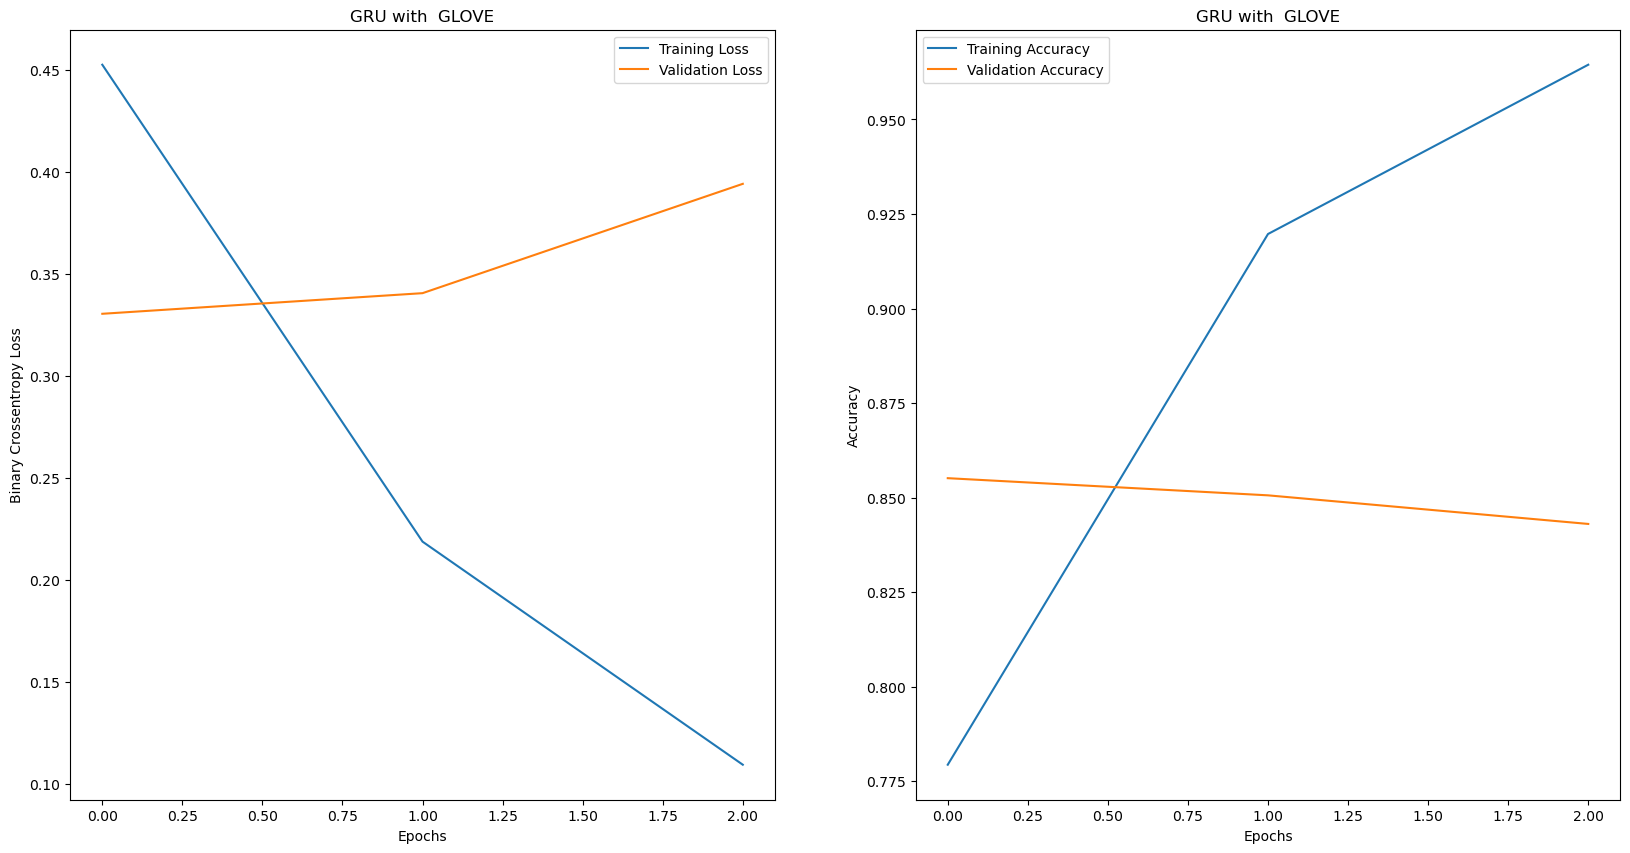

In [38]:
## ReLu with own embedding
plotCurves(modelMyr, "GRU with  GLOVE")